In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 30
pd.options.display.max_columns = 60

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install shap
!pip install lightgbm

In [29]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/opgg/12일차/2021_LoL_esports_match_data_from_OraclesElixir_20211201.csv')
df = df[df['league']=='LCK'].copy()
df.reset_index(drop=True, inplace=True)
columns = list(df.columns)

In [ ]:
#df.shape

In [ ]:
#df.head()

In [30]:
summary_df = df.copy()

summary_df['killsdiffat15'] = summary_df['killsat15'] - summary_df['opp_killsat15']
summary_df['assistsdiffat15'] = summary_df['assistsat15'] - summary_df['opp_assistsat15']
summary_df['deathsdiffat15'] = summary_df['deathsat15'] - summary_df['opp_deathsat15']
summary_df = summary_df.replace({'deaths':0}, {'deaths':1})
summary_df['KDA'] = (summary_df['kills'] + summary_df['assists'])/(summary_df['deaths'])

summary_col_list = ['playername','position',
 'golddiffat15','xpdiffat15','csdiffat15',
 'killsdiffat15','assistsdiffat15','deathsdiffat15',
 'damagetochampions','damageshare',
 'damagemitigatedperminute', 'wardsplaced','wardskilled',
 'controlwardsbought','visionscore','totalgold','total cs','monsterkills',
 'monsterkillsownjungle','monsterkillsenemyjungle','firstblood',
 'firstdragon','dragons','elders','firstherald',
 'heralds','firstbaron','barons','firsttower','towers',
 'result','KDA']

time_col_list = ['damagetochampions','damageshare',
 'damagemitigatedperminute', 'wardsplaced','wardskilled',
 'controlwardsbought','visionscore','totalgold','total cs','monsterkills',
 'monsterkillsownjungle','monsterkillsenemyjungle']

for col in time_col_list:
    summary_df[col] = summary_df[col]/summary_df['gamelength']

summary_df = summary_df[summary_col_list].copy()

In [31]:
dup_p = summary_df.groupby('playername', as_index=False)[['position']].nunique()
dup_p = dup_p[dup_p['position']>=2]
dup_p_list = list(dup_p['playername'])

In [32]:
for player in dup_p_list:
    else_p = summary_df[summary_df['playername']==player]['position'].value_counts().keys()[1]
    index = summary_df[summary_df['playername']==else_p].index
    summary_df = summary_df.drop(index)

In [33]:
top_df = summary_df[summary_df['position']=='top'].copy()
top_df = top_df.drop(columns=['position'])
top_df = top_df.reset_index(drop=True)
top_df = top_df.dropna(axis=1)

mid_df = summary_df[summary_df['position']=='mid'].copy()
mid_df = mid_df.drop(columns=['position'])
mid_df = mid_df.reset_index(drop=True)
mid_df = mid_df.dropna(axis=1)

jng_df = summary_df[summary_df['position']=='jng'].copy()
jng_df = jng_df.drop(columns=['position'])
jng_df = jng_df.reset_index(drop=True)
jng_df = jng_df.dropna(axis=1)

bot_df = summary_df[summary_df['position']=='bot'].copy()
bot_df = bot_df.drop(columns=['position'])
bot_df = bot_df.reset_index(drop=True)
bot_df = bot_df.dropna(axis=1)

sup_df = summary_df[summary_df['position']=='sup'].copy()
sup_df = sup_df.drop(columns=['position'])
sup_df = sup_df.reset_index(drop=True)
sup_df = sup_df.dropna(axis=1)

team_df = summary_df[summary_df['position']=='team'].copy()
team_df = team_df.drop(columns=['position'])
team_df = team_df.reset_index(drop=True)
team_df = team_df.dropna(axis=1)

In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

def encoder(df):
    le = LabelEncoder()
    labels = le.fit_transform(df.iloc[:,0])
    df.iloc[:,0] = labels
    return df

top_df = encoder(top_df)
mid_df = encoder(mid_df)
jng_df = encoder(jng_df)
bot_df = encoder(bot_df)
sup_df = encoder(sup_df)

def scaler(df):
    scaler = MinMaxScaler()
    df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])
    return df

top_df = scaler(top_df)
mid_df = scaler(mid_df)
jng_df = scaler(jng_df)
bot_df = scaler(bot_df)
sup_df = scaler(sup_df)

In [35]:
bot_df

,playername,golddiffat15,xpdiffat15,csdiffat15,killsdiffat15,assistsdiffat15,deathsdiffat15,damagetochampions,damageshare,damagemitigatedperminute,wardsplaced,wardskilled,controlwardsbought,visionscore,totalgold,total cs,monsterkills,firstblood,result,KDA
0,12,0.492915,0.457888,0.484962,0.5,0.571429,0.500000,0.228736,0.200291,0.096531,0.151417,0.225348,0.623663,0.256370,0.675771,0.860204,0.343290,0.0,1.0,0.454545
1,7,0.507085,0.542112,0.515038,0.5,0.428571,0.500000,0.183728,0.194928,0.324684,0.315475,0.390991,0.283483,0.364680,0.598396,0.853151,0.554545,0.0,0.0,0.075758
2,7,0.384702,0.548069,0.447368,0.3,0.642857,0.500000,0.194784,0.143532,0.211331,0.023938,0.365724,0.137143,0.143442,0.343377,0.608897,0.255501,0.0,0.0,0.027273
3,12,0.615298,0.451931,0.552632,0.7,0.357143,0.500000,0.393924,0.383816,0.259012,0.371171,0.337104,0.411429,0.435660,0.828780,0.753908,0.479065,1.0,1.0,0.636364
4,5,0.663446,0.651602,0.597744,0.5,0.571429,0.500000,0.225977,0.447634,0.190123,0.133110,0.410828,0.467280,0.440592,0.675815,0.919904,0.279822,0.0,1.0,0.227273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,3,0.237037,0.478841,0.462406,0.2,0.500000,0.833333,0.230447,0.217218,0.242324,0.100731,0.223531,0.309655,0.354689,0.471473,0.654705,0.288449,0.0,1.0,0.121212
974,5,0.352335,0.217338,0.387218,0.5,0.500000,0.500000,0.293721,0.250319,0.148311,0.147770,0.338349,0.447205,0.349681,0.400349,0.703222,0.364506,0.0,0.0,0.136364
975,3,0.647665,0.782662,0.612782,0.5,0.500000,0.500000,0.512597,0.446655,0.125603,0.269086,0.081706,0.447205,0.210034,0.466279,0.631366,0.221307,0.0,1.0,0.386364
976,3,0.351852,0.414339,0.484962,0.4,0.642857,0.166667,0.385356,0.560524,0.082503,0.326153,0.225374,0.415818,0.329548,0.366237,0.616298,0.193670,0.0,0.0,0.181818


In [36]:
# pip install lightgbm

In [37]:
top_df.drop(columns=['result'])

,playername,golddiffat15,xpdiffat15,csdiffat15,killsdiffat15,assistsdiffat15,deathsdiffat15,damagetochampions,damageshare,damagemitigatedperminute,wardsplaced,wardskilled,controlwardsbought,visionscore,totalgold,total cs,monsterkills,firstblood,KDA
0,10,0.722478,0.822894,0.437500,0.8,0.583333,0.1,0.521206,0.472512,0.220937,0.204099,0.760680,0.430409,0.536071,0.830052,0.730708,0.533713,1.0,0.650000
1,3,0.277522,0.177106,0.562500,0.2,0.416667,0.9,0.201437,0.228361,0.105037,0.576940,0.221865,0.591812,0.221209,0.136630,0.401615,0.000000,0.0,0.007143
2,3,0.395803,0.474195,0.468750,0.4,0.333333,0.6,0.628125,0.538526,0.335949,0.405170,0.115000,0.260278,0.173488,0.342421,0.627753,0.124134,0.0,0.033333
3,10,0.604197,0.525805,0.531250,0.6,0.666667,0.4,0.411937,0.354955,0.342655,0.200201,0.153333,0.325347,0.082820,0.738730,0.735453,0.198614,0.0,0.650000
4,1,0.478155,0.592633,0.390625,0.5,0.583333,0.4,0.124754,0.265353,0.153080,0.230331,0.111952,0.316725,0.180088,0.408627,0.545966,0.132929,1.0,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,9,0.310721,0.333039,0.539062,0.2,0.583333,0.6,0.207000,0.197505,0.133855,0.349593,0.311591,0.528914,0.460652,0.563954,0.740495,0.336338,1.0,0.100000
974,1,0.501150,0.419938,0.554688,0.4,0.500000,0.6,0.461394,0.381482,0.076558,0.198864,0.281250,0.424366,0.362512,0.407339,0.483458,0.283349,0.0,0.080000
975,9,0.498850,0.580062,0.445312,0.6,0.500000,0.4,0.384959,0.280608,0.285929,0.332539,0.250000,0.583503,0.244249,0.657718,0.632334,0.141674,0.0,0.233333
976,9,0.485915,0.498236,0.328125,0.6,0.583333,0.3,0.143578,0.198978,0.195312,0.411292,0.387423,0.657636,0.489499,0.371657,0.470120,0.200733,1.0,0.300000


In [38]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

ftr = mid_df.drop(columns=['result'])
target = mid_df.result

X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)

lgbm_warpper = LGBMClassifier(verbose=0)

evals = [(X_test, y_test)]
lgbm_warpper.fit(X_train, y_train, early_stopping_rounds = 100,
                eval_metric='logloss', eval_set = evals, verbose = True)
preds = lgbm_warpper.predict(X_test)

[1]	valid_0's binary_logloss: 0.631703	valid_0's binary_logloss: 0.631703
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.586722	valid_0's binary_logloss: 0.586722
[3]	valid_0's binary_logloss: 0.548946	valid_0's binary_logloss: 0.548946
[4]	valid_0's binary_logloss: 0.515761	valid_0's binary_logloss: 0.515761
[5]	valid_0's binary_logloss: 0.486193	valid_0's binary_logloss: 0.486193
[6]	valid_0's binary_logloss: 0.46448	valid_0's binary_logloss: 0.46448
[7]	valid_0's binary_logloss: 0.445994	valid_0's binary_logloss: 0.445994
[8]	valid_0's binary_logloss: 0.426424	valid_0's binary_logloss: 0.426424
[9]	valid_0's binary_logloss: 0.41349	valid_0's binary_logloss: 0.41349
[10]	valid_0's binary_logloss: 0.402205	valid_0's binary_logloss: 0.402205
[11]	valid_0's binary_logloss: 0.39053	valid_0's binary_logloss: 0.39053
[12]	valid_0's binary_logloss: 0.379196	valid_0's binary_logloss: 0.379196
[13]	valid_0's binary_logloss: 0.368679	valid_0's bi

In [39]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lgbm_warpper, ftr, target, scoring = 'accuracy', cv=5)
print('교차 검증 정확도 : {}'.format(sum(scores/5)))

교차 검증 정확도 : 0.8844688644688645


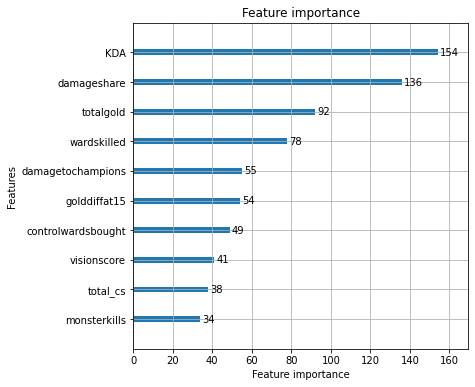

In [40]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline
# feature_importance 이외에도 importance를 구하는 방법 찾기

f, ax = plt.subplots(figsize=(6, 6))
plot_importance(lgbm_warpper, max_num_features=10, ax=ax)

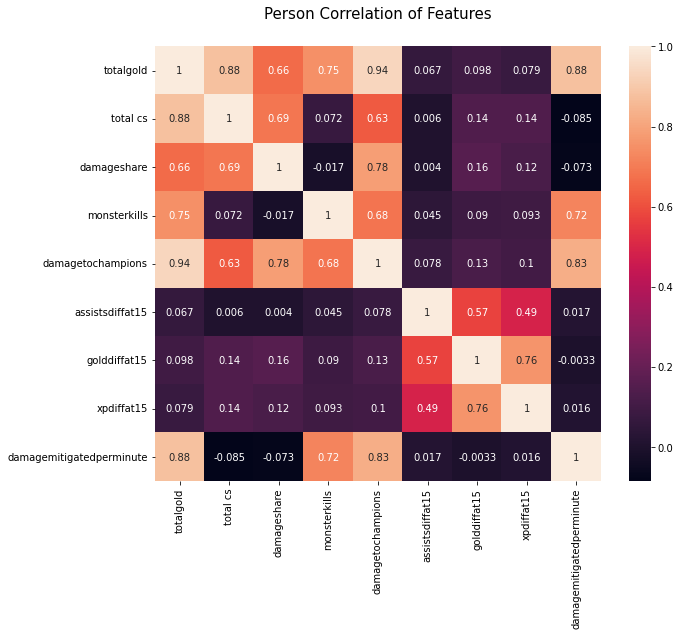

In [41]:
plt.figure(figsize=(10, 8))
plt.title("Person Correlation of Features", y = 1.05, size = 15)
sns.heatmap(summary_df[['totalgold','total cs', 'damageshare', 'monsterkills', 'damagetochampions', 'assistsdiffat15', \
    'golddiffat15', 'xpdiffat15', 'damagemitigatedperminute']].corr(), annot=True)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


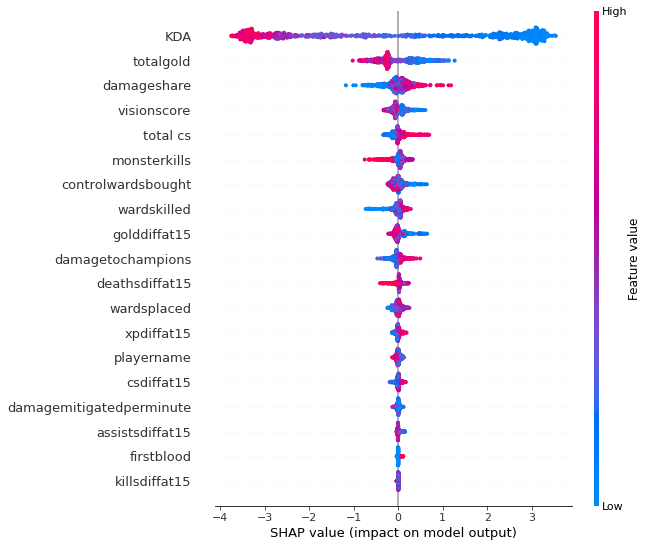

In [42]:
import shap
# load js 
shap.initjs()

'''
KernelExplainer() : KNN, SVM, RandomForest, GBM, H2O 
TreeExplainer() : tree-based machine learning model (faster) 
DeepExplainer() : deep learning model 
'''

explainer = shap.TreeExplainer(lgbm_warpper)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[0], X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


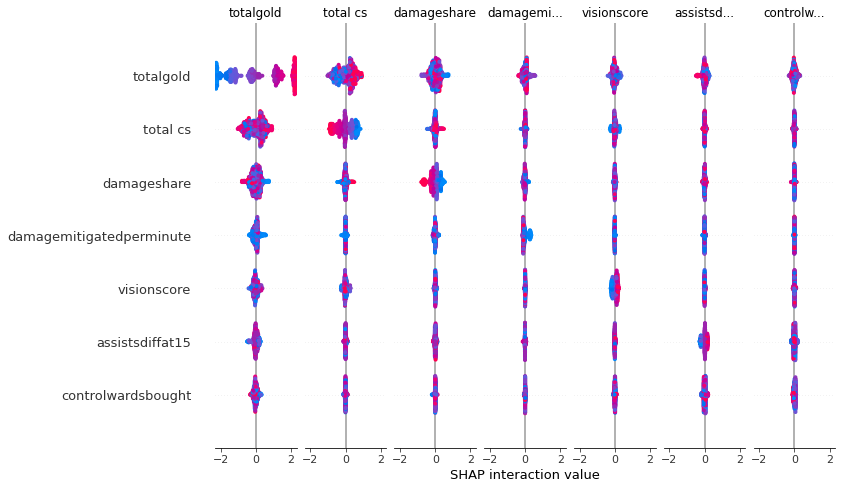

In [19]:
import shap
# load js 
shap.initjs()

'''
KernelExplainer() : KNN, SVM, RandomForest, GBM, H2O 
TreeExplainer() : tree-based machine learning model (faster) 
DeepExplainer() : deep learning model 
'''

explainer = shap.TreeExplainer(lgbm_warpper)
shap_values = explainer.shap_values(X_train)
shap_interaction_values = shap.TreeExplainer(lgbm_warpper).shap_interaction_values(X_train)
shap.summary_plot(shap_interaction_values, X_train)